In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.stats import binom, norm, beta

## Frequentist polling company

Suppose there is a large population of individuals, that support either candidate A or candidate B. We want to establish $p$ - the fraction of supporters of A in the population.

We will conduct an opinion poll asking about the support for each party. We will choose randomly a certain number of people, $n$, and ask them about their candidates.

We want to use the results of the poll to establish:
1.  an estimate of the true population parameter $p$
2.  our confidence about the interval

First, we define a formal model of sampling. We will assume that the population is much bigger than the small sample. Thus we will assume a *sampling with replacement* model: each person is selected independently at random from the full population. We call such a sample IID (Independent Identically Distributed).

Having the sampling model we establish that the number of supporters of A in the sample follows a *binomial distribution*. 

For the binomial distribution with $n$ trials and probability of success $p$ the expected number of successes is $n*p$ and the variance is $n*p*(p-1)$. 

Alternatively, the *fraction* of successes in the sample has the expected value $p$ and variance $\frac{p*(1-p)}{n}$. 

Lets plot the PMF (Probability Mass Function) of the number of successes.

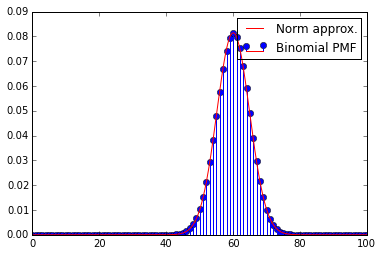

In [4]:
# model parameters
n = 100
p = 0.6

# the binomial distribution
model = binom(n=n, p=p)
x = arange(n+1)

# plot the PMF - probability mass function
stem(x, model.pmf(x), 'b', label='Binomial PMF')

# plot the normal approximation
mu = p * n
stdev = sqrt(p*(1-p) * n)
model_norm = norm(mu, stdev)
x_cont = linspace(x[0], x[-1], 1000)
plot(x_cont, model_norm.pdf(x_cont), 'r', label='Norm approx.')

legend()

Now lets create a sample from the binomial distribution. Please note, that fraction of A's supporters, $\mu$ 

In [38]:
sample = random.rand(n)<p

print ("Made %d trials. Fraction of A supporters: %f (true fraction: %f)" % 
       (n, 1.0*sample.sum()/n, p))

Made 100 trials. Fraction of A supporters: 0.560000 (true fraction: 0.600000)


In Machine Learning we only have access to the sample. The goal is to learn something useful about the unknown population. Here we are interested in the true heads probability $p$.

The MLE (Maximum Likelihood Estimator) for $p$ is just the sample mean $\mu$. However, how precise this is? We want the (sample dependent) confidence interval around the sample mean, such that in 95% of experiments (samples taken), the true unknown population parameter $p$ is in the confidence interval.

Formally we want to find $\mu$ and $\epsilon$ such that $P(\mu-\epsilon \leq p \leq \mu + \epsilon) > 0.95$ or, equivalently, such that $P(|p-\mu| \leq \epsilon) > 0.95$.

Note: from the sampling model we know that for a large enought sample (>15 persons) the probability of the sample mean $\mu$ is approximately normally distributed with mean $p$ and standard deviation $\sigma = \sqrt{(p*(1-p)/n)}$. However we do not know $p$. When designing the experiment, we can take the worse value, which is 0.5. Alternatively, we can plug for $p$ the estimated sample mean $\mu$. Note: we are being too optimistic here, but the error will be small.

For a standard normal random variable (mean 0 and standard deviation 1) 95% of samples fall within the range $\pm 1.95$. 

Therefore the confidence interval is approximately $\mu \pm 1.95*\sqrt{\frac{\mu(1-\mu)}{n}}$.


Average confidence interval is mu +-0.030192
Out of 10000 experiments, the true p fell into the confidence interval 9410 times.


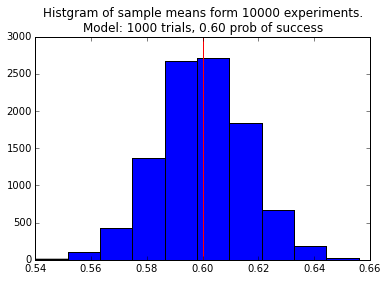

In [40]:
n=1000
n_experiments=10000

samples = rand(n_experiments, n)<p
mus = samples.mean(1)

hist(mus)
axvline([p], color='r')
title('Histgram of sample means form %d experiments.\n'
      'Model: %d trials, %.2f prob of success'%(n_experiments,n,p))

confidence_intervals = zeros((n_experiments, 2))
confidence_intervals[:,0] = mus - 1.95*np.sqrt(mus*(1-mus)/n)
confidence_intervals[:,1] = mus + 1.95*np.sqrt(mus*(1-mus)/n)

#note: this also works, can you exmplain how the formula works in numpy?
confidence_intervals2 = mus[:,None] + [-1.95, 1.95] * np.sqrt(mus*(1-mus)/n).reshape(-1,1)
assert np.abs(confidence_intervals-confidence_intervals2).max()==0

good_experiments = (confidence_intervals[:,0]<p) & (confidence_intervals[:,1]>p)

print ("Average confidence interval is mu +-%f" 
       % ((confidence_intervals[:,1]-confidence_intervals[:,0]).mean()/2.0,))

print ("Out of %d experiments, the true p fell into the confidence interval %d times."
       % (n_experiments, good_experiments.sum()))

Practical outcome: in the worst case ($p=0.5$) the 95% confidence interval is $\pm 1.95*\sqrt{\frac{0.5*(1-0.5)}{n}} = \pm \frac{0.975}{\sqrt{n}}$. To get the usually acceptable polling error of 3 percentage points, one needs to sample 1056 persons. Polling companies typically ask between 1000-3000 persons.

Questions:
1. How critical is the IID sampling assumption?
2. What do you think is a larger problem: approximating the PDF with a Gaussian distribution, or people lying in the questionnaire?

## Bayesian polling company

We will treat $p$ - the unknown fraction of A supporters in the population as a random variable. Its probability distribution will express *our subjective* uncertainty about its value.

We will need to start with a *prior* assumption about our belief of $p$. For convenience we will choose a *conjugate prior*, the Beta distribution, because the formula for its PDF is similar to the formula for the likelihood.

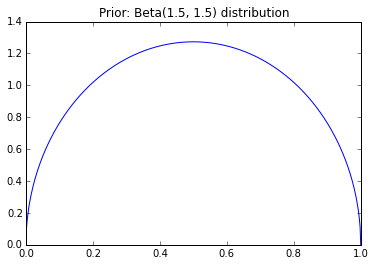

In [86]:
support = linspace(0,1,512)

A=1.5
B=1.5

plot(support, beta.pdf(support, A,B))
title("Prior: Beta(%.1f, %.1f) distribution" %(A,B))

Then we will collect samples, and after each sample update our belief about $p$.

In [87]:
n_successes = 0
n_failures = 0

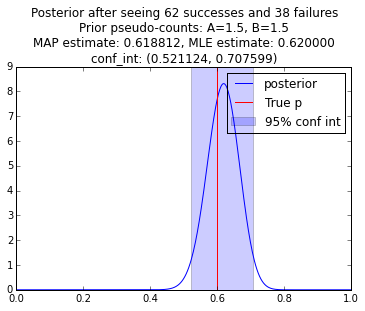

In [88]:
for _ in xrange(100):
    if rand()<p:
        n_successes += 1
    else:
        n_failures +=1

plot(support, beta.pdf(support, A+n_successes, B+n_failures), label='posterior')
axvline(p, color='r', label='True p')
conf_int_low, conf_int_high = beta.ppf((0.025,0.975), A+n_successes, B+n_failures)
axvspan(conf_int_low, conf_int_high, alpha=0.2, label='95% conf int')
title("Posterior after seeing %d successes and %d failures\n"
      "Prior pseudo-counts: A=%.1f, B=%.1f\n"
      "MAP estimate: %f, MLE estimate: %f\n"
      "conf_int: (%f, %f)"% (n_successes, n_failures, A, B, 
                             1.0*(A+n_successes-1)/(A+n_successes+B+n_failures-2),
                              1.0*n_successes/(n_successes+n_failures),
                              conf_int_low, conf_int_high))
legend()

Please note: in the Bayesian framework we treat the quantities we want to estimate as random variables. 

We need to define our prior beliefs about them. In the example, the prior was a Beta distribution.

After seeing the data we update our belief about the world. In the example, this is vary easy - we keep running counts of the number of failures and successes observed. We update them seeing the data. The prior conveniently can be treated as *pseudo-counts*. 

To summarize the distribution over the parameter, we typically take its mode (the most likely value), calling the approach MAP (Maximum a Posteriori).